In [1]:
%%capture
import kagglehub
from google.colab import userdata
username = userdata.get('KAGGLE_USERNAME')
key = userdata.get('KAGGLE_KEY')
%env KAGGLE_USERNAME=$username
%env KAGGLE_KEY=$key

In [2]:
!kaggle datasets download farhanwew/gastrointestinal-endoscopy-polyp-dataset

Dataset URL: https://www.kaggle.com/datasets/farhanwew/gastrointestinal-endoscopy-polyp-dataset
License(s): unknown
 79% 481M/605M [00:00<00:00, 1.68GB/s]
100% 605M/605M [00:00<00:00, 1.64GB/s]


In [3]:
%pip install -q dagshub 'mlflow>=2,<3'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 138.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 135.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.1 MB/s eta 0:00:00


In [5]:
%%capture
!unzip gastrointestinal-endoscopy-polyp-dataset.zip

In [6]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import shutil, random
import cv2, os, glob
import numpy as np
import pandas as pd
import mlflow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


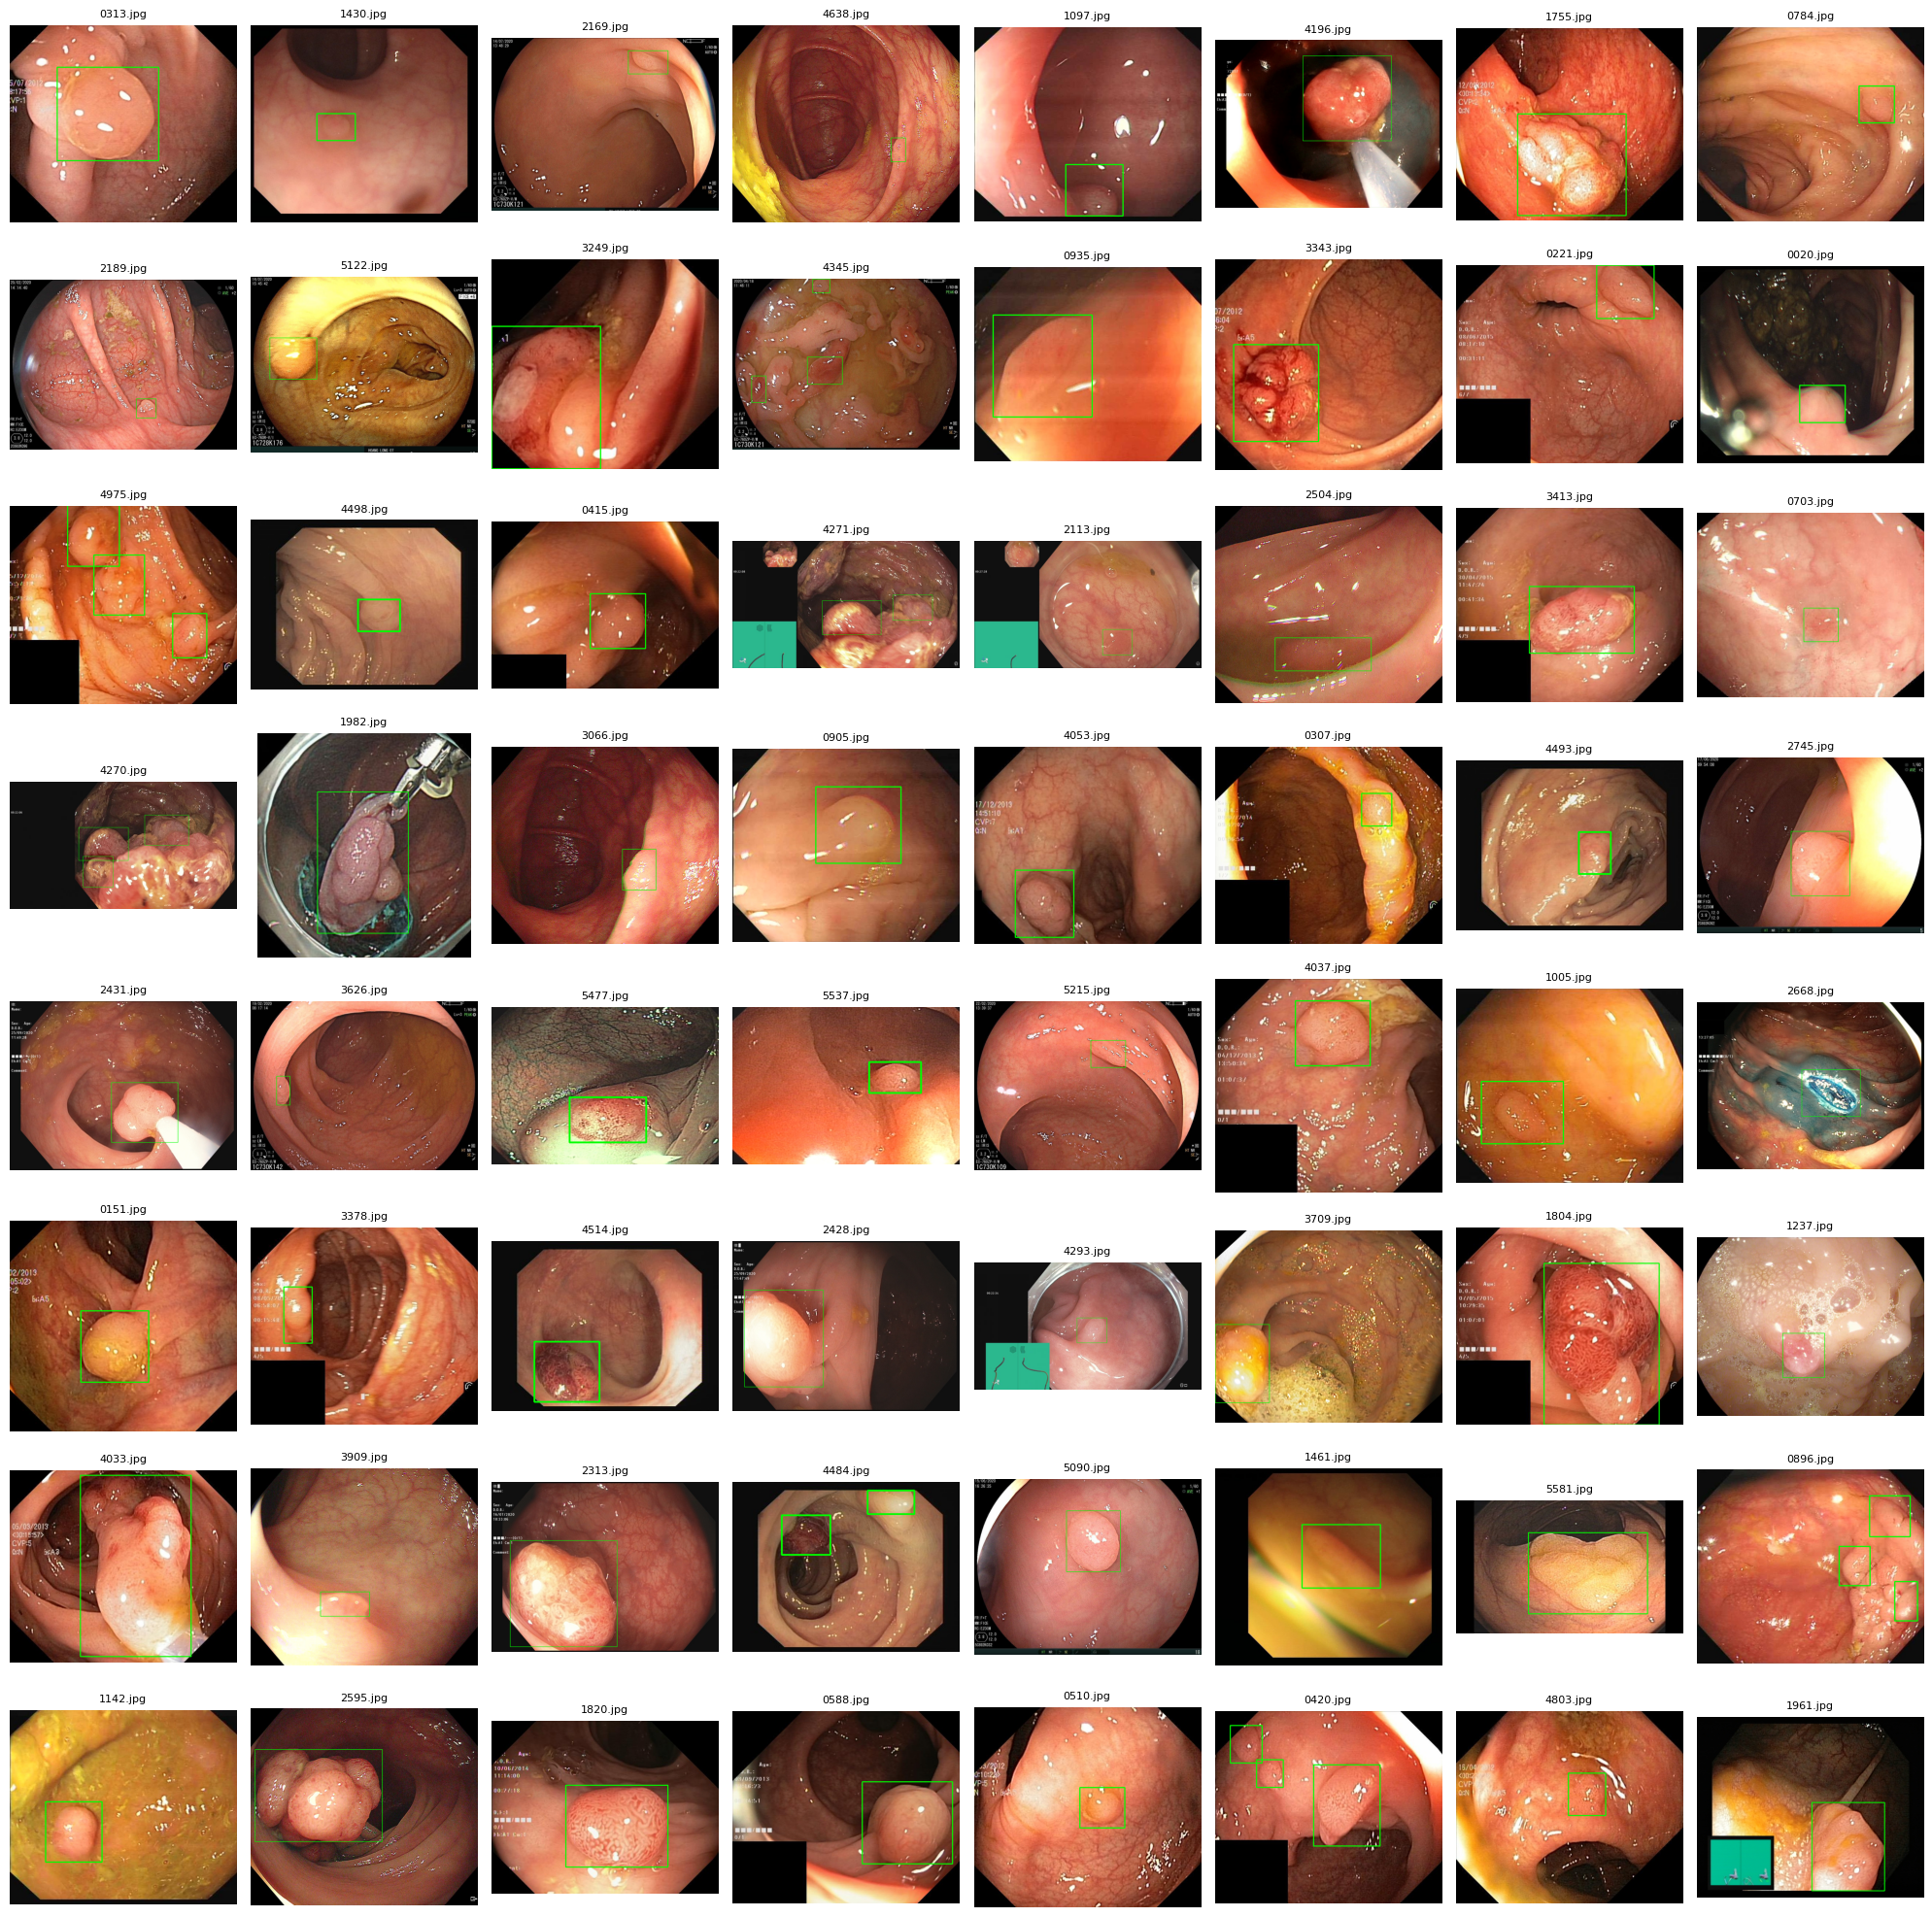

In [8]:
# === Paths ===
img_dir = "Gastrointestinal endoscopy polyp dataset/Polyp-Images"
label_dir = "Gastrointestinal endoscopy polyp dataset/TXT-Labels"

# === Ambil daftar gambar ===
images = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(images)

# === Pilih 64 gambar secara acak ===
sample_images = images[:64]

# === Fungsi untuk menggambar bounding box YOLO ===
def draw_yolo_boxes(image_path, label_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    h, w, _ = img.shape
    if not os.path.exists(label_path):
        return img

    with open(label_path, "r") as f:
        for line in f:
            cls, x_center, y_center, bw, bh = map(float, line.strip().split())
            x_center, y_center, bw, bh = x_center * w, y_center * h, bw * w, bh * h
            x1 = int(x_center - bw / 2)
            y1 = int(y_center - bh / 2)
            x2 = int(x_center + bw / 2)
            y2 = int(y_center + bh / 2)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# === Plot 8x8 grid ===
plt.figure(figsize=(20, 20))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(img_dir, img_name)
    label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + ".txt")
    img = draw_yolo_boxes(img_path, label_path)
    if img is not None:
        plt.subplot(8, 8, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(img_name), fontsize=8)

plt.tight_layout()
plt.show()

In [9]:
# Path dataset asli
base = "Gastrointestinal endoscopy polyp dataset"
images_dir = os.path.join(base, "Polyp-Images")
labels_dir = os.path.join(base, "TXT-Labels")

# Path dataset baru
splits = ["train", "val", "test"]
for split in splits:
    os.makedirs(os.path.join(base, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(base, split, "labels"), exist_ok=True)

# Ambil semua file gambar
images = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]
random.shuffle(images)

# Rasio pembagian
train_split = 0.7   # 70% train
val_split   = 0.2   # 20% val
test_split  = 0.1   # 10% test

n = len(images)
train_idx = int(n * train_split)
val_idx   = train_idx + int(n * val_split)

# Bagi dataset
for i, img_name in enumerate(images):
    src_img = os.path.join(images_dir, img_name)
    src_lbl = os.path.join(labels_dir, img_name.replace(".jpg", ".txt"))

    if i < train_idx:
        dst_img, dst_lbl = "train/images", "train/labels"
    elif i < val_idx:
        dst_img, dst_lbl = "val/images", "val/labels"
    else:
        dst_img, dst_lbl = "test/images", "test/labels"

    shutil.copy(src_img, os.path.join(base, dst_img, img_name))
    shutil.copy(src_lbl, os.path.join(base, dst_lbl, img_name.replace(".jpg", ".txt")))

print("✅ Dataset dibagi jadi Train/Val/Test")

✅ Dataset dibagi jadi Train/Val/Test


In [10]:
%%writefile data.yaml

train: /content/Gastrointestinal endoscopy polyp dataset/train/images
val: /content/Gastrointestinal endoscopy polyp dataset/val/images
test: /content/Gastrointestinal endoscopy polyp dataset/test/images

nc: 1
names: ['polyp']

Writing data.yaml


In [11]:
! yolo settings mlflow=True

✅ Updated 'mlflow=True'
JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": false,
  "vscode_msg": true,
  "openvino_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


In [12]:
! yolo settings wandb=True

✅ Updated 'wandb=True'
JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": true,
  "vscode_msg": true,
  "openvino_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


In [13]:
! yolo settings tensorboard=True

✅ Updated 'tensorboard=True'
JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": true,
  "vscode_msg": true,
  "openvino_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


In [14]:
import dagshub
dagshub.init(repo_owner='farhanwew', repo_name='polyp-object-detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=ff004307-7bae-41aa-a62a-8abe17acfc66&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=594a8c31ddda80e83b6f6bab73bca4c12de7d1d901199537394f0a25082a0026




Accessing as farhanwew

Initialized MLflow to track repo "farhanwew/polyp-object-detection"

Repository farhanwew/polyp-object-detection initialized!

In [21]:
os.environ["WANDB_API_KEY"] = userdata.get('WANDB_KEY')

In [ ]:
!yolo train \
  data="/content/data.yaml" \
  model=yolov8n.pt \
  epochs=50 \
  imgsz=640 \
  batch=64\
  name=Percobaan_2 \
  project= Model_yolo_8

Ultralytics 8.3.207 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Percobaan_23, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

In [ ]:
BASE = "/content/Gastrointestinal endoscopy polyp dataset"
TEST_IM_DIR  = os.path.join(BASE, "test/images")
TEST_LBL_DIR = os.path.join(BASE, "test/labels")
OUT_DIR      = "/content/test_inference_overlay"
CSV_FILE     = "/content/test_metrics.csv"

os.makedirs(OUT_DIR, exist_ok=True)

# Load model terbaik
model = YOLO("Model_yolo_8/Percobaan_23/weights/best.pt")

In [ ]:
# Jalankan inference
test_images = sorted(
    [p for ext in ("*.jpg","*.jpeg","*.png") for p in glob.glob(os.path.join(TEST_IM_DIR, ext))]
)
results = model.predict(source=test_images, imgsz=640, conf=0.25, iou=0.5, verbose=False)

# ========================================
# 3. Hitung metric per-gambar + overlay
# ========================================
def box_iou(a, b):
    if len(a)==0 or len(b)==0:
        return np.zeros((len(a), len(b)))
    ious = np.zeros((len(a), len(b)))
    a_areas = (a[:,2]-a[:,0]) * (a[:,3]-a[:,1])
    b_areas = (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])
    for i in range(len(a)):
        ax1, ay1, ax2, ay2 = a[i]
        inter_x1 = np.maximum(ax1, b[:,0])
        inter_y1 = np.maximum(ay1, b[:,1])
        inter_x2 = np.minimum(ax2, b[:,2])
        inter_y2 = np.minimum(ay2, b[:,3])
        inter_w  = np.maximum(0, inter_x2 - inter_x1)
        inter_h  = np.maximum(0, inter_y2 - inter_y1)
        inter    = inter_w * inter_h
        union    = a_areas[i] + b_areas - inter
        ious[i]  = np.where(union > 0, inter/union, 0.0)
    return ious

rows = []
for res in results:
    img = cv2.imread(res.path)
    h, w = img.shape[:2]

    # Prediksi dari YOLO
    pred_xyxy = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.zeros((0,4))
    confs     = res.boxes.conf.cpu().numpy() if res.boxes is not None else np.zeros((0,))
    classes   = res.boxes.cls.cpu().numpy().astype(int) if res.boxes is not None else np.zeros((0,))

    # Ground truth dari label
    gt_file = os.path.join(TEST_LBL_DIR, os.path.splitext(os.path.basename(res.path))[0] + ".txt")
    gts = []
    if os.path.exists(gt_file):
        for line in open(gt_file):
            cls, xc, yc, bw, bh = map(float, line.strip().split())
            x1, y1 = (xc-bw/2)*w, (yc-bh/2)*h
            x2, y2 = (xc+bw/2)*w, (yc+bh/2)*h
            gts.append([x1,y1,x2,y2])
    gt_xyxy = np.array(gts)

    # Matching by IoU
    iou_mat = box_iou(pred_xyxy, gt_xyxy)
    TP = sum(iou_mat.max(axis=1) >= 0.5) if len(pred_xyxy)>0 else 0
    FP = len(pred_xyxy) - TP
    FN = len(gt_xyxy) - TP

    prec = TP / (TP+FP) if (TP+FP)>0 else 0
    rec  = TP / (TP+FN) if (TP+FN)>0 else 0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0

    rows.append({
        "image": os.path.basename(res.path),
        "num_gt": len(gt_xyxy),
        "num_pred": len(pred_xyxy),
        "TP": TP, "FP": FP, "FN": FN,
        "precision": prec, "recall": rec, "f1": f1
    })

    # Overlay prediksi (merah)
    for (x1,y1,x2,y2), c in zip(pred_xyxy, confs):
        cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255), 2)
        cv2.putText(img, f"Pred {c:.2f}", (int(x1),int(y1)-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

    # Overlay GT (hijau)
    for (x1,y1,x2,y2) in gt_xyxy:
        cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 2)
        cv2.putText(img, "GT", (int(x1),int(y1)-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    cv2.imwrite(os.path.join(OUT_DIR, os.path.basename(res.path)), img)

# ========================================
# 4. Simpan CSV + Log ke MLflow
# ========================================
df = pd.DataFrame(rows)
df.to_csv(CSV_FILE, index=False)
print("✅ CSV metric per-image:", CSV_FILE)
print("✅ Overlay images:", OUT_DIR)

mlflow.set_experiment("Model_yolo_8")
with mlflow.start_run(run_name="inference-test-percobaan_1"):
    mlflow.log_artifact(CSV_FILE)
    mlflow.log_artifacts(OUT_DIR, artifact_path="overlay")
print("📦 Metrics + Overlay dilog ke MLflow")